# Project on German credit

# Packages

In [1]:
import pandas as pd 
import numpy as np 
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,classification_report,auc
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf 
import tensorflow.keras as keras 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import initializers

# Load dataset 

In [3]:

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

file = r'D:\sklearn\german.data'
df = pd.read_csv(file,names = names, delimiter = ' ')
print("German Credit Data set", df.head() )
print("Data set shape", df.shape )

German Credit Data set   existingchecking  duration credithistory purpose  creditamount savings  \
0              A11         6           A34     A43          1169     A65   
1              A12        48           A32     A43          5951     A61   
2              A14        12           A34     A46          2096     A61   
3              A11        42           A32     A42          7882     A61   
4              A11        24           A33     A40          4870     A61   

  employmentsince  installmentrate statussex otherdebtors  ...  property age  \
0             A75                4       A93         A101  ...      A121  67   
1             A73                2       A92         A101  ...      A121  22   
2             A74                2       A93         A101  ...      A121  49   
3             A74                2       A93         A103  ...      A122  45   
4             A73                3       A93         A101  ...      A124  53   

   otherinstallmentplans housing existi

# Data Analysis

# Data cleaning 

In [4]:
# Transformation de la variable classification -> 0 = 'bad' credit; 1 = 'good' credit
df.classification.replace([1,2], [1,0], inplace=True)
# Nombre de 'good' credits  and 'bad credits
df.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

In [6]:
#Variables nurmeriques 
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

#Variables categorielles 
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker'] 

In [7]:
#Centration-reduction des variables numeriques 
numdata_std = pd.DataFrame(StandardScaler().fit_transform(df[numvars].drop(['classification'], axis=1)))

In [8]:
#Codification des variables categorielles 
d = defaultdict(LabelEncoder)
lecatdf = df[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", df[catvars[x]].unique())
    print(catvars[x],": ", lecatdf[catvars[x]].unique())

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


In [9]:
#One hot encoding, creation d'une variable binanire pour chaque variable categorielle 
dummyvars = pd.get_dummies(df[catvars])

In [10]:
#Creation de la clean database 
data_clean = pd.concat([df[numvars], dummyvars], axis = 1)
print("German credit clean dataset", data_clean.head())
print("Clean dataset set shape", data_clean.shape )

German credit clean dataset    creditamount  duration  installmentrate  residencesince  age  \
0          1169         6                4               4   67   
1          5951        48                2               2   22   
2          2096        12                2               3   49   
3          7882        42                2               4   45   
4          4870        24                3               4   53   

   existingcredits  peopleliable  classification  existingchecking_A11  \
0                2             1               1                     1   
1                1             1               0                     0   
2                1             2               1                     0   
3                1             2               1                     1   
4                2             2               0                     1   

   existingchecking_A12  ...  housing_A152  housing_A153  job_A171  job_A172  \
0                     0  ...             1  

# Train and test dataset

In [11]:
#Train set validation set 
x= data_clean.drop('classification', axis=1)
y = data_clean['classification']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)
y_test.value_counts()
y_train.value_counts()

x_train (750, 61)
x_test (250, 61)
y_train (750,)
y_test (250,)


1    524
0    226
Name: classification, dtype: int64

# Classification algorithms

# Functions

In [31]:
 #Fonction d'evaluation 
def evaluation(model,X,Y):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(model, X, Y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(model, X, Y, cv=2, scoring='precision')
    scores3 = cross_val_score(model, X, Y, cv=2, scoring='recall')
    scores4 = cross_val_score(model, X, Y, cv=2, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    return  

In [107]:
def compute_roc(y_true, y_pred, plot=True):
    fpr = dict()
    tpr = dict()
    auc_score = dict()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.legend(loc="upper right")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.show()
    return fpr, tpr, auc_score

In [114]:
#Baseline mlp model 
def mlp_model(init,learning_rate):   
    
    # Model initialisation and layers specification
    model = tf.keras.Sequential()
    model.add(Dense(61,input_dim=61,kernel_initializer=init, activation = 'relu'))
    model.add(Dense(1,kernel_initializer=init, activation='sigmoid'))
    
    # Initialisation of the optimizer
    adam = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile model 
    model.compile(loss=binary_crossentropy, optimizer=adam, metrics=['accuracy']) 
    return model

# Gradient boosting model
def xgboost(params, X_train, y_train,X_test, y_test):
    print('XGBoost v',xgb.__version__)
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    model = XGBClassifier(**params).\
      fit(X_train, y_train, eval_set=eval_set, \
                  eval_metric='auc', early_stopping_rounds = 100, verbose=100)
        
    print(model.best_ntree_limit)

    model.set_params(**{'n_estimators': model.best_ntree_limit})
    model.fit(X_train, y_train)
    print(model,'\n')
    
    # Predict target variables y for test data
    y_pred = model.predict(X_test, ntree_limit=model.best_ntree_limit) 
    print(y_pred)
   
    #Get Cross Validation and Confusion matrix
    evaluation(model, X_train, y_train)
    
    
    # Create and print confusion matrix    
    cfm = confusion_matrix(y_test,y_pred)
    print(cfm)
    
    print (classification_report(y_test,y_pred) )
    print ('\n')
    print ("XGBoost model Accuracy: %.6f" %accuracy_score(y_test,y_pred) )
    
    # ROC Curve
    print("ROC curve")
    compute_roc(y_test, y_pred, plot=True)
    
    return model



# fit, train and cross validate Logisitc regression with training and test data 
def logreg(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    model = LogisticRegression().fit(X_train, y_train)
    print(model,'\n')
    
    # Predict target variables y for test data
    y_pred = model.predict(X_test)
    
    print (classification_report(y_test,y_pred) )
    
    # Create and print confusion matrix 
    print("confusion matrix")
    cfm = confusion_matrix(y_test,y_pred)
    print(cfm)
    
    # Create and print confusion matrix
    print("ROC curve")
    compute_roc(y_test, y_pred, plot=True)
    
    # Get Cross Validation and Confusion matrix on the test dataset
    evaluation(model, x_test, y_test)
    return 

LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 

              precision    recall  f1-score   support

           0       0.57      0.49      0.53        74
           1       0.80      0.85      0.82       176

    accuracy                           0.74       250
   macro avg       0.68      0.67      0.67       250
weighted avg       0.73      0.74      0.73       250

confusion matrix
[[ 36  38]
 [ 27 149]]
ROC curve


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


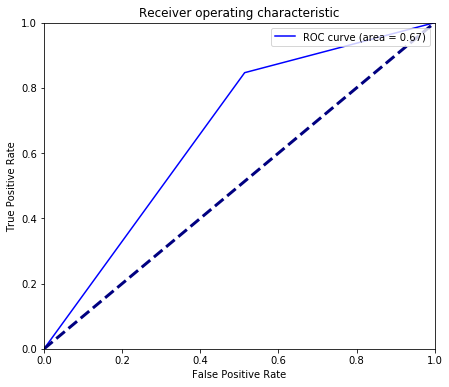

Cross Validation Accuracy: 0.72 (+/- 0.02)
Cross Validation Precision: 0.80 (+/- 0.01)
Cross Validation Recall: 0.80 (+/- 0.01)
Cross Validation roc_auc: 0.74 (+/- 0.05)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [113]:
# Logistic Regression
logreg(x_train, y_train,x_test,y_test)

# Tunning Hyperparameters with Gridsearch

In [72]:
print('MLP with grid search')
# Model creation with keras wrapper
estimator = KerasClassifier(build_fn=mlp_model,verbose=0)

# grid search epochs, batch size, learning_rate, initialiazer
batches = [100]
lr = [ 0.01, 0.001]
init = ['normal', 'uniform','glorot_uniform']
epochs = [10, 15]
param_grid = dict(epochs=epochs, learning_rate=lr, batch_size = batches, init = init)
grid = GridSearchCV(estimator, param_grid=param_grid,
                    return_train_score=False,
                    scoring=['accuracy', 'roc_auc'],
                    refit= 'accuracy')

grid_result = grid.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [73]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_roc_auc']
stds = grid_result.cv_results_['std_test_roc_auc']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.698667 using {'batch_size': 100, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01}
0.586305 (0.066845) with: {'batch_size': 100, 'epochs': 10, 'init': 'normal', 'learning_rate': 0.01}
0.570448 (0.043446) with: {'batch_size': 100, 'epochs': 10, 'init': 'normal', 'learning_rate': 0.001}
0.474582 (0.008924) with: {'batch_size': 100, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01}
0.578466 (0.052316) with: {'batch_size': 100, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.001}
0.592305 (0.082950) with: {'batch_size': 100, 'epochs': 10, 'init': 'glorot_uniform', 'learning_rate': 0.01}
0.528225 (0.037168) with: {'batch_size': 100, 'epochs': 10, 'init': 'glorot_uniform', 'learning_rate': 0.001}
0.626984 (0.048101) with: {'batch_size': 100, 'epochs': 15, 'init': 'normal', 'learning_rate': 0.01}
0.605927 (0.012406) with: {'batch_size': 100, 'epochs': 15, 'init': 'normal', 'learning_rate': 0.001}
0.487319 (0.021933) with: {'batch_size': 100, 'epochs': 15, 'init': 'unif

In [79]:
print('XGBoost with grid search')
params={
    'learning_rate': [0.01, 0.02],
    'max_depth': [3],
    #'subsample': [0.6]
    #'colsample_bytree': [0.5],
    'n_estimators': [50, 100, 200, 300, 400, 500]
    #'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}


estimator = xgb.XGBClassifier()

grid_xgb = GridSearchCV(estimator,
                  params,
                  cv=2,
                  scoring="roc_auc",
                  n_jobs=1,
                  verbose=False)
grid_xgb.fit(x_train, y_train)
best_est = grid_xgb.best_estimator_
print(best_est)
print(grid_xgb.best_score_)

print('Cross validation of Gridsearch best estimator')
evaluation(best_est,x_test,y_test)

XGBoost with grid search
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
0.7710008106464905
Roc AUC with test data of Gridsearch best estimator
0.7645116707616708
Cross validation of Gridsearch best estimator
Cross Validation Accuracy: 0.73 (+/- 0.00)
Cross Validation Precision: 0.78 (+/- 0.01)
Cross Validation Recall: 0.85 (+/- 0.01)
Cross Validation roc_auc: 0.76 (+/- 0.04)


# Model implementation

In [106]:
# Logistic Regression implmentation
logreg(x_train, y_train,x_test,y_test)

LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 

[[ 36  38]
 [ 27 149]]
              precision    recall  f1-score   support

           0       0.57      0.49      0.53        74
           1       0.80      0.85      0.82       176

    accuracy                           0.74       250
   macro avg       0.68      0.67      0.67       250
weighted avg       0.73      0.74      0.73       250

Cross Validation Accuracy: 0.72 (+/- 0.02)
Cross Validation Precision: 0.80 (+/- 0.01)
Cross Validation Recall: 0.80 (+/- 0.01)
Cross Validation roc_auc: 0.74 (+/- 0.05)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [70]:
#MLP implementation 

best_pipe = grid_result.best_estimator_
print('Scorer:' , grid_result.scorer_)
print('Best_score: %.5f' % grid_result.best_score_)
#y_pred = best_pipe.predict(x_test)
#print(y_pred)
score = best_pipe.score(x_test, y_test)
print('Score on the test set: %.5f' % score)

print('Cross validation of Gridsearch best estimator')
evaluation(best_pipe,x_test,y_test)

Scorer: {'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}
Best_score: 0.70533
Score on the test set: 0.70400
Cross validation of Gridsearch best estimator
Cross Validation Accuracy: 0.56 (+/- 0.11)
Cross Validation Precision: 0.38 (+/- 0.38)
Cross Validation Recall: 1.00 (+/- 0.00)
Cross Validation roc_auc: 0.44 (+/- 0.09)


XGBoost v 1.0.2
[0]	validation_0-auc:0.82772	validation_1-auc:0.73772
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:1.00000	validation_1-auc:0.73833
5
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 

[0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1

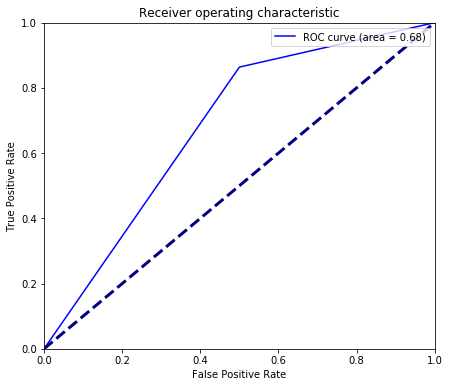

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [115]:
#Xgboost implementation 
#Baseline model
params={}
xgboost(params, x_train, y_train, x_test, y_test)

In [55]:
# Train xgboost
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)
param = {'max_depth' : 3, 'eta' : 0.1, 'objective' : 'binary:logistic', 'seed' : 42}
num_round = 50
bst = xgb.train(param, dtrain, num_round, [(dtest, 'test'), (dtrain, 'train')])

[0]	test-error:0.31200	train-error:0.27067
[1]	test-error:0.29200	train-error:0.24133
[2]	test-error:0.30400	train-error:0.25733
[3]	test-error:0.30400	train-error:0.25467
[4]	test-error:0.26400	train-error:0.22933
[5]	test-error:0.25600	train-error:0.21467
[6]	test-error:0.24400	train-error:0.22133
[7]	test-error:0.26000	train-error:0.22267
[8]	test-error:0.24800	train-error:0.21333
[9]	test-error:0.24800	train-error:0.20800
[10]	test-error:0.24000	train-error:0.20800
[11]	test-error:0.24800	train-error:0.21200
[12]	test-error:0.25200	train-error:0.20933
[13]	test-error:0.25200	train-error:0.20533
[14]	test-error:0.25200	train-error:0.20400
[15]	test-error:0.24400	train-error:0.20267
[16]	test-error:0.24000	train-error:0.20533
[17]	test-error:0.24000	train-error:0.20000
[18]	test-error:0.23600	train-error:0.19067
[19]	test-error:0.23600	train-error:0.18933
[20]	test-error:0.23600	train-error:0.18933
[21]	test-error:0.22800	train-error:0.18533
[22]	test-error:0.23200	train-error:0.1853

In [56]:
preds = bst.predict(dtest)
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0
print(accuracy_score(preds, y_test), 1 - accuracy_score(preds, y_test))

0.776 0.22399999999999998
